This notebook documents part 2 of the complementarity of image and demographic information: the ability of latent space extracted from Autoencoders to predict mode choice and trip generation.

In [36]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_version = '1571'

model_type = 'AE'
model_code = 'BM1_A1'
sampling = 's'

zoomlevel = 'zoom13'
output_dim = 1
model_run_date = '220211'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [4]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [5]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Trip Behavior

In [6]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()
# train_test_index = np.random.rand(len(df_pivot)) < 0.2

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [7]:
x_train = aggregate_embeddings[~train_test_index, :]
x_test = aggregate_embeddings[train_test_index, :]

# 1. Linear Regression

### 1.1 Auto Share
Highlight:

Auto Lasso
Parameter: 4.00e-06 Train R2: 0.6226 	 Test R: 0.6770 	 Nonzero coef: 81

Auto Ridge
Parameter: 2.00e-03 Train R2: 0.6554 	 Test R: 0.6694

PT Lasso
Parameter: 6.00e-06 Train R2: 0.4318 	 Test R: 0.4435 	 Nonzero coef: 22

PT Ridge
Parameter: 5.00e-03 Train R2: 0.5089 	 Test R: 0.4509

Active Lasso
Parameter: 3.00e-06 Train R2: 0.5354 	 Test R: 0.5541 	 Nonzero coef: 85

Active Ridge
Parameter: 3.00e-03 Train R2: 0.5592 	 Test R: 0.5524

Trip Gen Lasso
Parameter: 1.00e-03 Train R2: 0.0400 	 Test R: 0.0301 	 Nonzero coef: 13

Trip Gen Ridge
Parameter: 5.00e-02 Train R2: 0.0555 	 Test R: 0.0162

In [9]:
auto_train = y[~train_test_index,1]
auto_test = y[train_test_index,1]

In [11]:
# Linear Regression without Regularization
lr = linear_model.LinearRegression()
lr.fit(x_train, auto_train)
# with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#     f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
#         lr.score(x_train, auto_train), lr.score(x_test, auto_test), 'lr', zoomlevel,
#         np.sum(lr.coef_ != 0), len(lr.coef_)))
print("Train R2: %.4f \t Test R2: %.4f" % (lr.score(x_train, auto_train), lr.score(x_test, auto_test)))

Train R2: 1.0000 	 Test R2: -0.4400


In [17]:
# Lasso
for a in (1e-6)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, auto_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, auto_train), 
                                                                                  lasso.score(x_test, auto_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.156e-02, tolerance: 7.704e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

Parameter: 0.00e+00 Train R2: 0.9984 	 Test R: -0.7392 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.783e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-07 Train R2: 0.9454 	 Test R: 0.2914 	 Nonzero coef: 1132


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-06 Train R2: 0.7122 	 Test R: 0.6494 	 Nonzero coef: 282


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.945e-02, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.00e-06 Train R2: 0.6604 	 Test R: 0.6727 	 Nonzero coef: 156
Parameter: 3.00e-06 Train R2: 0.6376 	 Test R: 0.6763 	 Nonzero coef: 114
Parameter: 4.00e-06 Train R2: 0.6226 	 Test R: 0.6770 	 Nonzero coef: 81
Parameter: 5.00e-06 Train R2: 0.6134 	 Test R: 0.6752 	 Nonzero coef: 63
Parameter: 6.00e-06 Train R2: 0.6055 	 Test R: 0.6717 	 Nonzero coef: 53
Parameter: 7.00e-06 Train R2: 0.5982 	 Test R: 0.6666 	 Nonzero coef: 48
Parameter: 8.00e-06 Train R2: 0.5917 	 Test R: 0.6608 	 Nonzero coef: 39
Parameter: 1.00e-05 Train R2: 0.5826 	 Test R: 0.6534 	 Nonzero coef: 31
Parameter: 2.00e-05 Train R2: 0.5549 	 Test R: 0.6273 	 Nonzero coef: 14
Parameter: 5.00e-05 Train R2: 0.4927 	 Test R: 0.5396 	 Nonzero coef: 7


In [21]:
# Ridge

for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, auto_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, auto_train), 
                                                              ridge.score(x_test, auto_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "


Parameter: 0.00e+00 Train R2: 0.9959 	 Test R: -0.4623
Parameter: 1.00e-04 Train R2: 0.7900 	 Test R: 0.6202
Parameter: 1.00e-03 Train R2: 0.6796 	 Test R: 0.6655
Parameter: 2.00e-03 Train R2: 0.6554 	 Test R: 0.6694
Parameter: 3.00e-03 Train R2: 0.6421 	 Test R: 0.6693
Parameter: 4.00e-03 Train R2: 0.6330 	 Test R: 0.6678
Parameter: 5.00e-03 Train R2: 0.6260 	 Test R: 0.6659
Parameter: 6.00e-03 Train R2: 0.6203 	 Test R: 0.6636
Parameter: 7.00e-03 Train R2: 0.6155 	 Test R: 0.6612
Parameter: 8.00e-03 Train R2: 0.6112 	 Test R: 0.6586
Parameter: 1.00e-02 Train R2: 0.6039 	 Test R: 0.6534
Parameter: 2.00e-02 Train R2: 0.5776 	 Test R: 0.6271
Parameter: 5.00e-02 Train R2: 0.5246 	 Test R: 0.5617


### 1.2 PT

In [23]:
pt_train = y[~train_test_index,3]
pt_test = y[train_test_index,3]

# Lasso
for a in (1e-6)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, pt_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, pt_train), 
                                                                                  lasso.score(x_test, pt_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-02, tolerance: 1.373e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg,

Parameter: 0.00e+00 Train R2: 0.9960 	 Test R: -1.8425 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.159e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-07 Train R2: 0.8526 	 Test R: 0.2409 	 Nonzero coef: 799


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.311e-03, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-06 Train R2: 0.5404 	 Test R: 0.4324 	 Nonzero coef: 161
Parameter: 2.00e-06 Train R2: 0.4969 	 Test R: 0.4397 	 Nonzero coef: 81
Parameter: 3.00e-06 Train R2: 0.4728 	 Test R: 0.4403 	 Nonzero coef: 59
Parameter: 4.00e-06 Train R2: 0.4532 	 Test R: 0.4408 	 Nonzero coef: 42
Parameter: 5.00e-06 Train R2: 0.4409 	 Test R: 0.4423 	 Nonzero coef: 29
Parameter: 6.00e-06 Train R2: 0.4318 	 Test R: 0.4435 	 Nonzero coef: 22
Parameter: 7.00e-06 Train R2: 0.4260 	 Test R: 0.4408 	 Nonzero coef: 17
Parameter: 8.00e-06 Train R2: 0.4215 	 Test R: 0.4387 	 Nonzero coef: 16
Parameter: 1.00e-05 Train R2: 0.4121 	 Test R: 0.4336 	 Nonzero coef: 14
Parameter: 2.00e-05 Train R2: 0.3690 	 Test R: 0.3912 	 Nonzero coef: 7
Parameter: 5.00e-05 Train R2: 0.2584 	 Test R: 0.2642 	 Nonzero coef: 3


In [24]:
# Ridge

for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, pt_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, pt_train), 
                                                              ridge.score(x_test, pt_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "


Parameter: 0.00e+00 Train R2: 0.9838 	 Test R: -1.5064
Parameter: 1.00e-04 Train R2: 0.7145 	 Test R: 0.3986
Parameter: 1.00e-03 Train R2: 0.5733 	 Test R: 0.4392
Parameter: 2.00e-03 Train R2: 0.5437 	 Test R: 0.4469
Parameter: 3.00e-03 Train R2: 0.5278 	 Test R: 0.4495
Parameter: 4.00e-03 Train R2: 0.5170 	 Test R: 0.4506
Parameter: 5.00e-03 Train R2: 0.5089 	 Test R: 0.4509
Parameter: 6.00e-03 Train R2: 0.5024 	 Test R: 0.4508
Parameter: 7.00e-03 Train R2: 0.4970 	 Test R: 0.4505
Parameter: 8.00e-03 Train R2: 0.4923 	 Test R: 0.4500
Parameter: 1.00e-02 Train R2: 0.4846 	 Test R: 0.4488
Parameter: 2.00e-02 Train R2: 0.4597 	 Test R: 0.4398
Parameter: 5.00e-02 Train R2: 0.4185 	 Test R: 0.4089


### 1.3 Active

In [27]:
active_train = y[~train_test_index,0]
active_test = y[train_test_index,0]

for a in (1e-6)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, active_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, active_train), 
                                                                                  lasso.score(x_test, active_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.582e-02, tolerance: 3.791e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max

Parameter: 0.00e+00 Train R2: 0.9976 	 Test R: -1.6841 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-07 Train R2: 0.9115 	 Test R: 0.1510 	 Nonzero coef: 1013


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.146e-01, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-06 Train R2: 0.6169 	 Test R: 0.5213 	 Nonzero coef: 238
Parameter: 2.00e-06 Train R2: 0.5626 	 Test R: 0.5487 	 Nonzero coef: 134
Parameter: 3.00e-06 Train R2: 0.5354 	 Test R: 0.5541 	 Nonzero coef: 85
Parameter: 4.00e-06 Train R2: 0.5183 	 Test R: 0.5513 	 Nonzero coef: 60
Parameter: 5.00e-06 Train R2: 0.5059 	 Test R: 0.5517 	 Nonzero coef: 45
Parameter: 6.00e-06 Train R2: 0.4972 	 Test R: 0.5472 	 Nonzero coef: 39
Parameter: 7.00e-06 Train R2: 0.4887 	 Test R: 0.5425 	 Nonzero coef: 35
Parameter: 8.00e-06 Train R2: 0.4815 	 Test R: 0.5367 	 Nonzero coef: 28
Parameter: 1.00e-05 Train R2: 0.4714 	 Test R: 0.5276 	 Nonzero coef: 22
Parameter: 2.00e-05 Train R2: 0.4385 	 Test R: 0.4899 	 Nonzero coef: 12
Parameter: 5.00e-05 Train R2: 0.3489 	 Test R: 0.3816 	 Nonzero coef: 4


In [28]:
# Ridge

for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, active_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, active_train), 
                                                              ridge.score(x_test, active_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "


Parameter: 0.00e+00 Train R2: 0.9969 	 Test R: -0.8904
Parameter: 1.00e-04 Train R2: 0.7400 	 Test R: 0.5110
Parameter: 1.00e-03 Train R2: 0.6048 	 Test R: 0.5468
Parameter: 2.00e-03 Train R2: 0.5754 	 Test R: 0.5514
Parameter: 3.00e-03 Train R2: 0.5592 	 Test R: 0.5524
Parameter: 4.00e-03 Train R2: 0.5481 	 Test R: 0.5521
Parameter: 5.00e-03 Train R2: 0.5396 	 Test R: 0.5509
Parameter: 6.00e-03 Train R2: 0.5327 	 Test R: 0.5494
Parameter: 7.00e-03 Train R2: 0.5268 	 Test R: 0.5476
Parameter: 8.00e-03 Train R2: 0.5218 	 Test R: 0.5457
Parameter: 1.00e-02 Train R2: 0.5132 	 Test R: 0.5414
Parameter: 2.00e-02 Train R2: 0.4840 	 Test R: 0.5187
Parameter: 5.00e-02 Train R2: 0.4311 	 Test R: 0.4605


### 1.4 Trip Generation

In [32]:
trpgen_train = y[~train_test_index,-1]
trpgen_test = y[train_test_index,-1]

for a in (1e-4)*np.array([0,0.1,6,7,8,10,11,12,13,14,15,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, trpgen_train), 
                                                                                  lasso.score(x_test, trpgen_test), 
                                                                                  np.sum(lasso.coef_ != 0)))
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+03, tolerance: 3.630e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max

Parameter: 0.00e+00 Train R2: 0.9938 	 Test R: -3.8934 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.006e+04, tolerance: 3.630e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-05 Train R2: 0.8816 	 Test R: -1.1713 	 Nonzero coef: 1176
Parameter: 6.00e-04 Train R2: 0.0692 	 Test R: 0.0130 	 Nonzero coef: 38
Parameter: 7.00e-04 Train R2: 0.0549 	 Test R: 0.0223 	 Nonzero coef: 25
Parameter: 8.00e-04 Train R2: 0.0473 	 Test R: 0.0281 	 Nonzero coef: 18
Parameter: 1.00e-03 Train R2: 0.0400 	 Test R: 0.0301 	 Nonzero coef: 13
Parameter: 1.10e-03 Train R2: 0.0374 	 Test R: 0.0301 	 Nonzero coef: 11
Parameter: 1.20e-03 Train R2: 0.0353 	 Test R: 0.0293 	 Nonzero coef: 10
Parameter: 1.30e-03 Train R2: 0.0334 	 Test R: 0.0290 	 Nonzero coef: 9
Parameter: 1.40e-03 Train R2: 0.0320 	 Test R: 0.0281 	 Nonzero coef: 8
Parameter: 1.50e-03 Train R2: 0.0306 	 Test R: 0.0271 	 Nonzero coef: 8
Parameter: 2.00e-03 Train R2: 0.0228 	 Test R: 0.0230 	 Nonzero coef: 5
Parameter: 5.00e-03 Train R2: 0.0076 	 Test R: 0.0035 	 Nonzero coef: 2


In [34]:
# Ridge

for a in (1e-2)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, trpgen_train), 
                                                              ridge.score(x_test, trpgen_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "


Parameter: 0.00e+00 Train R2: 0.9954 	 Test R: -3.3639
Parameter: 1.00e-03 Train R2: 0.2700 	 Test R: -0.1056
Parameter: 1.00e-02 Train R2: 0.1170 	 Test R: -0.0025
Parameter: 2.00e-02 Train R2: 0.0855 	 Test R: 0.0103
Parameter: 3.00e-02 Train R2: 0.0707 	 Test R: 0.0142
Parameter: 4.00e-02 Train R2: 0.0617 	 Test R: 0.0157
Parameter: 5.00e-02 Train R2: 0.0555 	 Test R: 0.0162
Parameter: 6.00e-02 Train R2: 0.0509 	 Test R: 0.0162
Parameter: 7.00e-02 Train R2: 0.0474 	 Test R: 0.0161
Parameter: 8.00e-02 Train R2: 0.0445 	 Test R: 0.0158
Parameter: 1.00e-01 Train R2: 0.0401 	 Test R: 0.0152
Parameter: 2.00e-01 Train R2: 0.0291 	 Test R: 0.0120
Parameter: 5.00e-01 Train R2: 0.0184 	 Test R: 0.0069


# 2. Linear Regression (PyTorch)

In [82]:
mseloss = nn.MSELoss(reduction='mean')

In [67]:
def pytorch_lr(w1_list, lr_list, x1, x2, y1, y2):
    
    
    trainset = SurveyDataset(torch.tensor(x1,  dtype=torch.float), torch.tensor(y1, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    testset = SurveyDataset(torch.tensor(x2, dtype=torch.float), torch.tensor(y2, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    # decay rates for embedding
#     w1_list = [1.5]
    # decay rates for demo (There is no demo in this case)
    w2_list = [0]
    # lr_list = [0.005,0.01, 0.02]
#     lr_list = [0.002]

    dim_demo = 0
    dim_embed = x1.shape[1]

    for lr in lr_list:

        for w1, w2 in itertools.product(w1_list, w2_list):

            # model setup
            model = linear_reg.LR(dim_embed=dim_embed, dim_demo=dim_demo)

            embed_params = []
            demo_params = []
            other_params = []
            for name, m in model.named_parameters():
        #             print(name)
                if 'embed' in name:
                    embed_params.append(m)
                elif 'demo' in name:
                    demo_params.append(m)
                else:
                    other_params.append(m)

            optimizer = torch.optim.SGD([{'params':embed_params,'weight_decay':w1},
                                          {'params':demo_params,'weight_decay':w2},
                                          {'params':other_params,'weight_decay':0}], lr=lr)

            # model training
            ref1 = 0
            ref2 = 0

            for epoch in range(1000):

                mse_ = 0

                for batch, (x_batch, y_batch) in enumerate(trainloader):
                    # Compute prediction and loss
                    pred = model(x_batch, None)
                    pred = F.relu(pred).squeeze()

                    mse = mseloss(pred, y_batch)
                    mse_ += mse.item()

                    # Backpropagation
                    optimizer.zero_grad()
                    mse.backward()
                    optimizer.step()

                train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
                train_rmse = np.sqrt(mse_/len(trainset))

                if epoch % 20 == 0:
                    print(f"[epoch: {epoch:>3d}] Train RMSE : {train_rmse:.4f} R2 score: {train_r:.3f} ")
                loss_ = train_rmse

                if epoch % 5 == 0:
                    if epoch > 50:
                        if (np.abs(loss_ - ref1)/ref1<ref1*0.001) & (np.abs(loss_ - ref2)/ref2<ref2*0.001):
                            print("Early stopping at epoch", epoch)
                            break
                        if (ref1 < loss_) & (ref1 < ref2):
                            print("Diverging. stop.")
                            break
                        if loss_ < best:
                            best = loss_
                            best_epoch = epoch
                    else:
                        best = loss_
                        best_epoch = epoch

                    ref2 = ref1
                    ref1 = loss_

                if epoch % 20 == 0:

                    mse_ = 0 

                    for batch, (x_batch, y_batch) in enumerate(testloader):
                        pred = model(x_batch, None)
                        pred = F.relu(pred).squeeze()

                        mse = mseloss(pred, y_batch)
                        mse_ += mse.item()

                    test_rmse = np.sqrt(mse_/len(testset))
                    test_r = r2_score(y_batch.numpy(),pred.detach().numpy())

                    print(f"[epoch: {epoch:>3d}] Test RMSE {test_rmse:.4f} R2 score: {test_r:.3f} ")

    #         with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
    #             f.write("%s,%s,%s,%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
    #                 (model_run_date, model_type, zoomlevel, "LR", lr, w1, 
    #                   train_rmse, train_r, test_rmse, test_r))

In [78]:
pytorch_lr(w1_list=[0.00001], lr_list=[1], x1=x_train, x2=x_test, y1=auto_train, y2=auto_test)


[epoch:   0] Train RMSE : 0.0214 R2 score: -10.921 
[epoch:   0] Test RMSE 0.0651 R2 score: -12.113 
[epoch:  20] Train RMSE : 0.0214 R2 score: -10.921 
[epoch:  20] Test RMSE 0.0651 R2 score: -12.113 
[epoch:  40] Train RMSE : 0.0214 R2 score: -10.921 
[epoch:  40] Test RMSE 0.0651 R2 score: -12.113 
Early stopping at epoch 55


In [81]:
pytorch_lr(w1_list=[0.00001], lr_list=[0.5], x1=x_train, x2=x_test, y1=pt_train, y2=pt_test)


[epoch:   0] Train RMSE : 0.0032 R2 score: -0.502 
[epoch:   0] Test RMSE 0.0095 R2 score: -0.513 
[epoch:  20] Train RMSE : 0.0032 R2 score: -0.502 
[epoch:  20] Test RMSE 0.0095 R2 score: -0.513 
[epoch:  40] Train RMSE : 0.0032 R2 score: -0.502 
[epoch:  40] Test RMSE 0.0095 R2 score: -0.513 
Early stopping at epoch 55


In [71]:
torch.save(model.state_dict(), out_dir+"image_weights.pt")

# 2. MNL for Mode Share

In [29]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [9]:
sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)

In [10]:
wd_list = [0.00005]
lr_list = [0.01]

for (lr, wd) in itertools.product(lr_list, wd_list):
    print(lr, wd)
    # model setup
    model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # model training

    ref1 = 0
    ref2 = 0

    for epoch in range(400):

        kl_ = 0
        mse_ = 0
        mse1_ = 0
        mse2_ = 0
        mse3_ = 0
        mse4_ = 0

        for batch, (x_batch, y_batch) in enumerate(trainloader):
            # Compute prediction and loss
            util = model(x_batch)
            probs = torch.log(nn.functional.softmax(util, dim=1))
            kl = kldivloss(probs, y_batch)
    #         kl = kldivloss(torch.log(util), y_batch)
            kl_ += kl.item()

            mse = mseloss(torch.exp(probs), y_batch)
    #         mse = mseloss(util, y_batch)
            mse_ += mse.sum().item()
            mse1_ += mse[:,0].sum().item()
            mse2_ += mse[:,1].sum().item()
            mse3_ += mse[:,2].sum().item()
            mse4_ += mse[:,3].sum().item()
            mse = mse.sum()

            # Backpropagation
            optimizer.zero_grad()
            kl.backward()
            optimizer.step()

        train_kl = kl_/len(trainset)
        train_mse = np.sqrt(mse_/len(trainset))
        train_mse1 = np.sqrt(mse1_/len(trainset))
        train_mse2 = np.sqrt(mse2_/len(trainset))
        train_mse3 = np.sqrt(mse3_/len(trainset))
        train_mse4 = np.sqrt(mse4_/len(trainset))
        
        train_r1 = 1 - mse1_ / sst_train[0]
        train_r2 = 1 - mse2_ / sst_train[1]
        train_r3 = 1 - mse3_ / sst_train[2]
        train_r4 = 1 - mse4_ / sst_train[3]
        
        loss_ = train_kl

        if epoch % 5 == 0:
            
            kl_ = 0
            mse_ = 0 
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util,dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()

            test_kl = kl_/len(testset)
            test_mse = np.sqrt(mse_/len(testset))
            test_mse1 = np.sqrt(mse1_/len(testset))
            test_mse2 = np.sqrt(mse2_/len(testset))
            test_mse3 = np.sqrt(mse3_/len(testset))
            test_mse4 = np.sqrt(mse4_/len(testset))

            r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
            r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
            r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
            r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

            if epoch > 50:
                if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                    print("Early stopping at epoch", epoch)
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_epoch = epoch
                    output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                              test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                              r1, r2, r3, r4, train_r1, train_r2, train_r3, train_r4)
            else:
                best = loss_
                best_epoch = epoch
                output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                              test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                              r1, r2, r3, r4, train_r1, train_r2, train_r3, train_r4)
                
            ref2 = ref1
            ref1 = loss_
            
        if epoch % 20 == 0:
            print(f"[epoch: {epoch:>2d}] Train KL loss: {train_kl:.3f} \
                RMSE {train_mse:.3f} \
                {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
            print(f"\t\t\t\t\t\t\tR2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
            print(f"[epoch: {epoch:>2d}] Test KL loss: {kl_/len(testset):.3f}\
                RMSE {np.sqrt(mse_/len(testset)):.3f} \
                {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
            print(f"\t\t\t\t\t\t\tR2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")
            
    with open(out_dir+sampling+"_"+model_code+"_mode_choice.csv", "a") as f:
        f.write("%s,%s,%s,%s,%d,%.4f,%.5f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
            ((model_run_date, model_type, zoomlevel, "MNL", output_dim, lr, wd) + output))

0.01 5e-05
[epoch:  0] Train KL loss: 0.698                 RMSE 0.611                 0.197 0.511 0.195 0.188
							R2 score: -0.455 -3.791 -8.968 -2.630 
[epoch:  0] Test KL loss: 0.469                RMSE 0.486                 0.171 0.401 0.153 0.150
							R2 score: -0.194 -2.176 -14.844 -1.420 
[epoch: 20] Train KL loss: 0.221                 RMSE 0.295                 0.157 0.223 0.062 0.096
							R2 score: 0.085 0.089 -0.006 0.050 
[epoch: 20] Test KL loss: 0.200                RMSE 0.282                 0.150 0.216 0.040 0.095
							R2 score: 0.091 0.082 -0.060 0.035 
[epoch: 40] Train KL loss: 0.199                 RMSE 0.275                 0.146 0.205 0.062 0.092
							R2 score: 0.201 0.226 -0.006 0.135 
[epoch: 40] Test KL loss: 0.178                RMSE 0.261                 0.139 0.197 0.040 0.091
							R2 score: 0.219 0.232 -0.056 0.121 
[epoch: 60] Train KL loss: 0.182                 RMSE 0.259                 0.138 0.191 0.062 0.088
							R2 score: 0.286 0.330 -

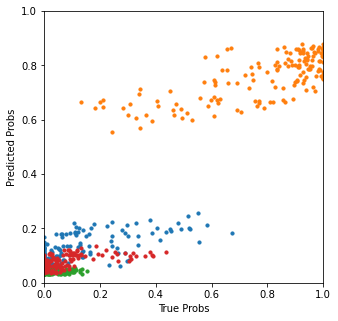

In [61]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()